<a href="https://colab.research.google.com/github/edwinnglabs/ts-playground/blob/master/Orbit_Tutorial.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# An Example of Forecasting / Nowcasting with DLT

In this session, we will explore:

- Orbit Installation
- A forecasting task on iclaims dataset
- A simple DLT model
- DLT model with regression settings
- Disgnoses

For more examples you can find on [Github](https://github.com/uber/Orbit).

# Installation

Install from PyPi (Run once):

In [1]:
# !pip install orbit-ml>=1.1.0
# !pip install matplotlib==3.1.3
# !pip install scikit-learn

In [2]:
%matplotlib inline

import os
import platform
import numpy as np
import matplotlib.pyplot as plt

import orbit
from orbit.utils.dataset import load_iclaims
from orbit.models import DLT
from orbit.diagnostics.plot import plot_predicted_data, plot_predicted_components
from orbit.diagnostics.metrics import smape
from sklearn.preprocessing import MinMaxScaler

In [3]:
seed=2022

In [4]:
print(orbit.__version__)
print(os.name)
print(platform.system())

1.1.0
posix
Linux


In [5]:
def mae(x, y):
    return np.mean(np.abs(x - y))

# US Weekly Initial Claims

The *iclaims* data contains the weekly initial claims for US unemployment benefits against a few related google trend queries (unemploy, filling and job) 
from Jan 2010 - June 2018. This dataset was used in the original Bayesian Structural Time-Series paper [Scott and Varan (2013)](https://people.ischool.berkeley.edu/~hal/Papers/2013/pred-present-with-bsts.pdf) as well.

Number of claims are obtained from [Federal Reserve Bank of St. Louis](https://fred.stlouisfed.org/series/ICNSA) while regressors such as google queries are obtained through [Google Trends API](https://trends.google.com/trends/?geo=US).

In order to use this data to nowcast the US unemployment claims considering the impact of COVID-19, we extended the dataset to Jan 2021 and added the [S&P 500 (^GSPC)](https://finance.yahoo.com/quote/%5EGSPC/history?period1=1264032000&period2=1611187200&interval=1wk&filter=history&frequency=1wk&includeAdjustedClose=true) and [VIX](https://finance.yahoo.com/quote/%5EVIX/history?p=%5EVIX) Index historical data for the same period.

**Note:** The data is standardized and log-transformed for the model fitting purpose.

In [6]:
# load data
df = load_iclaims(end_date='2021-01-03')
df = df[['week', 'claims', 'trend.unemploy', 'trend.job', 'sp500', 'vix']]

INFO:numexpr.utils:NumExpr defaulting to 2 threads.


In [7]:
df[['sp500']] = df[['sp500']].diff()
df = df[1:].reset_index(drop=True)

date_col = 'week'
response_col = 'claims'
df.dtypes

week              datetime64[ns]
claims                   float64
trend.unemploy           float64
trend.job                float64
sp500                    float64
vix                      float64
dtype: object

To introduce forecastability, we use 12 weeks lag of data for the regressors.

In [8]:
df[['trend.unemploy', 'trend.job', 'sp500', 'vix']] = df[['trend.unemploy', 'trend.job', 'sp500', 'vix']].shift(12)
df = df[12:].reset_index(drop=True)

In [9]:
df.head(5)

,week,claims,trend.unemploy,trend.job,sp500,vix
0,2010-04-04,12.950697,0.016351,0.181862,-0.007847,0.069878
1,2010-04-11,13.150243,0.032611,0.130569,-0.039749,0.491772
2,2010-04-18,12.987263,-0.000179,0.119987,-0.016522,0.388078
3,2010-04-25,12.969669,-0.069172,0.087552,-0.007177,0.446838
4,2010-05-02,12.897594,-0.182500,0.019344,0.008703,0.308205


We can see from the charts below, there are seasonlity, trend, and as well as a huge changpoint due the impact of COVID-19.

Text(0.5, 1.0, 'S&P500')

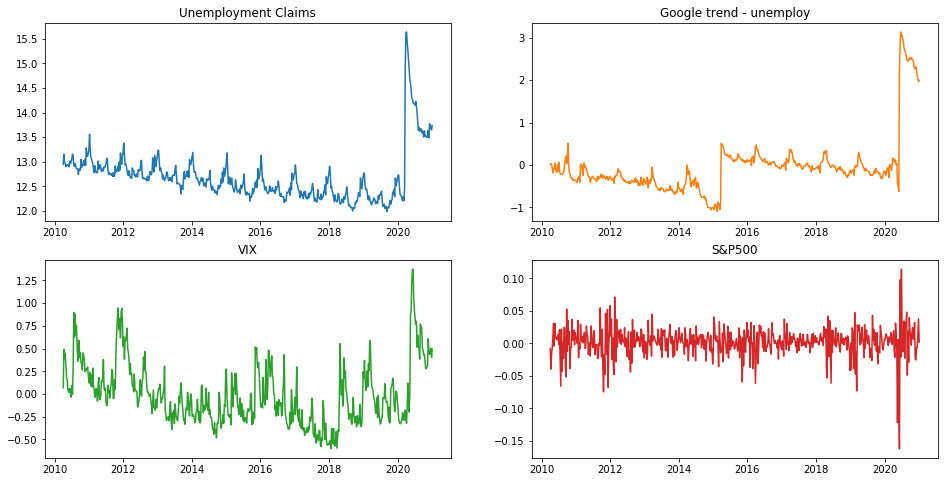

In [10]:
fig, axs = plt.subplots(2, 2, figsize=(16, 8))
axs[0, 0].plot(df['week'], df['claims'])
axs[0, 0].set_title('Unemployment Claims')
axs[0, 1].plot(df['week'], df['trend.unemploy'], 'tab:orange')
axs[0, 1].set_title('Google trend - unemploy')
axs[1, 0].plot(df['week'], df['vix'], 'tab:green')
axs[1, 0].set_title('VIX')
axs[1, 1].plot(df['week'], df['sp500'], 'tab:red')
axs[1, 1].set_title('S&P500')

## Train / Test Split

To make Bayesian priors comparable across regressors, we need some transformation across regressors.

In [11]:
# using relatively updated data
df = df[df['week'] > '2018-01-01'].reset_index(drop=True)
test_size = 12
train_df = df[:-test_size].reset_index(drop=True)
test_df = df[-test_size:].reset_index(drop=True)

scaler = MinMaxScaler()
train_df[['claims', 'trend.unemploy', 'trend.job', 'sp500', 'vix']] = scaler.fit_transform(train_df[['claims', 'trend.unemploy', 'trend.job', 'sp500', 'vix']])
test_df[['claims', 'trend.unemploy', 'trend.job', 'sp500', 'vix']] = scaler.transform(test_df[['claims', 'trend.unemploy', 'trend.job', 'sp500', 'vix']])

# Simple DLT Model

In [ ]:
dlt = DLT(
    response_col=response_col,
    date_col=date_col,
    seasonality=52,
    num_warmup=4000,
    num_sample=1000,
    estimator='stan-mcmc',
    seed=2022,
)

dlt.fit(df=train_df)
predicted_df = dlt.predict(df=test_df)

INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_05ff738ef22ce2e8a332ce639cee65cf NOW.


In [ ]:
# TODO: some bug on use_orbit_style=True
_ = plot_predicted_data(training_actual_df=train_df, predicted_df=predicted_df, 
                        date_col=date_col, actual_col=response_col, test_actual_df=test_df,
                        use_orbit_style=False,
                        title='DLT with Linear Global Trend')

# DLT With Regression

The regressor columns can be supplied via argument `regressor_col`.  Recall the regression formula in **DLT**:

$$
\hat{y}_t =\mu_t + s_t + r_t \\
r_t = \sum_{j}\beta_j x_{jt} \\
\beta_j ~\sim \mathcal{N}(\mu_j, \sigma_j^2)
$$

Let's use the default where $\mu_j = 0$ and $\sigma_j = 1$.  In addition, we can set a *sign* constraint for each coefficient $\beta_j$.  This is can be done by supplying the `regressor_sign` as a list where elements are in one of followings:

* '=': $\beta_j ~\sim \mathcal{N}(0, \sigma_j^2)$  i.e. $\beta_j \in (-\inf, \inf)$
* '+': $\beta_j ~\sim \mathcal{N}^+(0, \sigma_j^2)$  i.e. $\beta_j \in [0, \inf)$
* '-': $\beta_j ~\sim \mathcal{N}^-(0, \sigma_j^2)$  i.e. $\beta_j \in (-\inf, 0]$

Based on some intuition, it's reasonable to assume search terms such as "unemployment", "filling" and **VIX** index to be positively correlated and stock index such as **SP500** to be negatively correlated to the outcome.  Then we will leave whatever unsured as a regular regressor.

## Regular Regression

In [ ]:
dlt_reg = DLT(
    response_col=response_col, 
    date_col=date_col,
    regressor_col=['trend.unemploy', 'trend.job', 'sp500', 'vix'],
    seasonality=52,
    num_warmup=4000,
    num_sample=1000,
    estimator='stan-mcmc',
    seed=2022,
)

dlt_reg.fit(df=train_df)
predicted_df_reg = dlt_reg.predict(test_df, decompose=True)

In [ ]:
_ = plot_predicted_data(training_actual_df=train_df, predicted_df=predicted_df_reg, 
                        date_col=date_col, actual_col=response_col, test_actual_df=test_df,
                        use_orbit_style=False,
                        title='DLT with Regular Regresion')

The estimated regressor coefficients can be retrieved via `.get_regression_coefs()`.

In [ ]:
dlt_reg.get_regression_coefs()

### Diagnoses

#### Decomposition 

`plot_predicted_components` is the utility to plot each component separately. This is useful when one wants to look into the model prediction results and inspect each component separately.

In [ ]:
_ = plot_predicted_components(predicted_df_reg, date_col, 
                              use_orbit_style=False,
                              plot_components=['prediction', 'trend', 'seasonality', 'regression'])

#### Posterior Diagnostic Visualizations

In this section, we introduce to a few recommended diagnostic plots to diagnostic Orbit models. The posterior samples in SVI and Full Bayesian i.e. `FullBayesianForecaster` and `SVIForecaster`.

The plots are created by `ArviZ` for the plots. `ArviZ` is a Python package for exploratory analysis of Bayesian models, includes functions for posterior analysis, data storage, model checking, comparison and diagnostics.

1. Trace plot
2. Pair density plot

First, let's load the library.
-

In [ ]:
import arviz as az
az.style.use('arviz-darkgrid')

##### Trace plot

Trace plot shows the iterations of each paramter over the Markov chian sampling process. Trace plots provide an important tool for assessing mixing of a chain.

In [ ]:
ps = dlt_reg.get_posterior_samples(relabel=True, permute=False)
ps.keys()

In [ ]:
az.plot_trace(
    ps,
    var_names=['trend.unemploy', 'trend.job', 'sp500', 'vix', 'obs_sigma'],
    chain_prop={"color": ['r', 'b', 'g', 'y']},
    figsize=(10, 8),
);

##### Pair density plot

We can also check the density of samples by pair plot.

In [ ]:
az.plot_pair(
    ps,
    var_names=['trend.unemploy', 'trend.job', 'sp500', 'vix', 'obs_sigma'],
    kind=["scatter", "kde"],
    marginals=True,
    point_estimate="median",
    textsize=10.5,
    figsize=(8,8)
);

## Regression with Informative Priors / Regularized Priors

Assuming users obtain further knowledge on some of the regressors, they could use informative priors ($\mu$, $\sigma$) by replacing the defaults. This can be done via the arguments `regressor_beta_prior` and `regressor_sigma_prior`. These two lists should be of the same length as `regressor_col`.

In [ ]:
dlt_reg_adjust = DLT(
    response_col=response_col,
    date_col=date_col,
    regressor_col=['trend.unemploy', 'trend.job', 'sp500','vix'],
    regressor_sign=['+','=','-','+'],
    # regressor_beta_prior=[0.1, 0.01, -0.02, 0.01],
    regressor_sigma_prior=[0.1] * 4,
    num_warmup=4000,
    num_sample=1000,
    estimator='stan-mcmc',
    seed=2022,
)
dlt_reg_adjust.fit(df=train_df)
predicted_df_reg_adjust = dlt_reg_adjust.predict(test_df, decompose=True)

In [ ]:
_ = plot_predicted_data(training_actual_df=train_df, predicted_df=predicted_df_reg_adjust, 
                        date_col=date_col, actual_col=response_col, test_actual_df=test_df,
                        use_orbit_style=False,
                        title='DLT with Regresion of Informative Priors')

In [ ]:
dlt_reg_adjust.get_regression_coefs()

In [ ]:
naive_mae = mae(predicted_df['prediction'].values, test_df['claims'].values)
reg_mae = mae(predicted_df_reg['prediction'].values, test_df['claims'].values)
reg_adjust_mae = mae(predicted_df_reg_adjust['prediction'].values, test_df['claims'].values)

print('Naive Model: {:.3f}\nRegression Model: {:.3f}\nRefined Regression Model: {:.3f}'.format(
    naive_mae, reg_mae, reg_adjust_mae
))